In [284]:
import os
import glob

import datetime as dt

import numpy as np
import pandas as pd

from imblearn.over_sampling import BorderlineSMOTE, SMOTE

from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Functions

In [285]:
def label_condition(df):
    df['condition'] = 'clear'
    for index, row in df.iterrows():
        condition='clear'
        if row['fog tips'] > 0:
            df.loc[index, 'condition'] = 'fog'

        if row['rain (mm)'] > 0:
            df.loc[index, 'condition'] = 'rain'
        
        if (row['rain (mm)'] > 0) & (row['fog tips'] > 0):
            df.loc[index, 'condition'] = 'both'
    
    return df

def prep_data(src_fpath, var_subset=None):
    df = pd.read_csv(src_fpath, index_col=0)
    if var_subset:
        df = df[var_subset]
    else: 
        df = df.drop('fog', axis=1)  # Use fog tips
    df.dropna(inplace=True)
    df = label_condition(df)
    df['time (PST)'] = pd.to_datetime(df['time (PST)'])
    ## Break time into components
    df['month'] = df['time (PST)'].dt.year
    df['month'] = df['time (PST)'].dt.month
    df['day'] = df['time (PST)'].dt.day
    df['hour'] = df['time (PST)'].dt.hour
    #df['minute'] = df['time (PST)'].dt.minute
    #df.drop(['time (PST)'], axis=1, inplace=True)

    df.set_index('time (PST)', inplace=True)

    return df

def split_pred_target(df):
        X = df.drop(['fog tips', 'condition'], axis=1)
        y = df['condition']

        return X, y

def run_cv(rf, X_train, y_train): 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cv_result = cross_val_score(rf, X_train, y_train, cv=skf, scoring='f1_macro')
    return cv_result

def get_metrics(y_test, y_pred):
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    bal_acc = round(balanced_accuracy_score(y_test, y_pred),3)
    recall = round(recall_score(y_test, y_pred, average='macro'), 3)
    precision = round(precision_score(y_test, y_pred, average='macro'), 3)
    f1 = round(f1_score(y_test, y_pred, average='macro'), 3)

    metrics_dict = {
       "Accuracy" : accuracy, 
       "Balanced Accuracy" : bal_acc,
       "Recall" : recall, 
       "Precision" : precision,
       "F1" : f1}
    
    return metrics_dict

def plot_cm(y_test, y_pred, title=None, labels=['both', 'clear', 'fog', 'rain']):
    df = pd.DataFrame()
    df['actual'] = y_test
    df['pred'] = y_pred

    # Plot Confusion Matrix
    df = pd.DataFrame()
    df['actual'] = y_test
    df['pred'] = y_pred
    df.head()

    cm = confusion_matrix(y_test, y_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)

    cm_display.plot()
    if title:
        plt.title(title)
    plt.show() 


def fill_fog_periods(condition, fill_period=2):
    # Initialize variables
    n = len(condition)
    filled_condition = condition[:]  # Create a copy to modify

    # Iterate through the list to find 'dry' sequences
    i = 0
    while i < n:
        if filled_condition[i] != 'clear':  # Skip over 'fog'
            i += 1
            continue
        
        # Find a sequence of 'dry' values
        dry_start = i
        while i < n and filled_condition[i] == 'clear':
            i += 1
        dry_end = i  # The index where 'dry' sequence ends
        
        # Check if the 'dry' sequence is 2 or fewer and replace with 'fog'
        if dry_end - dry_start <= fill_period:
            for j in range(dry_start, dry_end):
                filled_condition[j] = 'fog'
    
    return filled_condition

In [286]:
def cv_wrapper(src_fpath, model, var_subset=None):
    df = prep_data(src_fpath, var_subset)

    # Drop rain/both observations for now
    df= df.loc[~df['condition'].isin(['both', 'rain'])]

    # Prepare train/test sets
    X, y = split_pred_target(df)
    y = fill_fog_periods(y, fill_period=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.3, stratify=y, shuffle=True)   
    #X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_train, y_train)

    # Run CV 
    cv_result = run_cv(model, X_train, y_train)
    print(cv_result)

    return cv_result

def ml_wrapper(model, X_test, y_test):
    y_pred = model.predict(X_test)

# Parameters

In [287]:
#### Specify parameters #### 
seed = 1234

src_datadir = '/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/02_clean'

# Subset common to all datasets
#var_subset = ['time (PST)', 'fog tips', 'air temperature (C)', 'relative humidity (%)', 'rain (mm)', 'wind speed (m/s)', 'wind gust (m/s)', 'wind direction (deg)']
var_subset = ['time (PST)', 'fog tips', 'air temperature (C)', 'relative humidity (%)', 'rain (mm)', 'wind speed (m/s)', 'wind gust (m/s)', 'wind direction (deg)']
rf = RandomForestClassifier(
        random_state=seed,
        class_weight='balanced'
    )

In [288]:
# Create a dictionary to store results
cv_dict = {
    "site" : [],
    "subset" : [],
    "mean_score" : []
}

## Pozo 

In [ ]:
src_fname = 'sci-pozo-smo2-clean-2021-2023.csv'
src_fpath = os.path.join(src_datadir, src_fname)

# Run with all variables 
cv_results = cv_wrapper(src_fpath, rf)
mean_score = round(np.average(cv_results), 3)
print("Full Dataset Mean F1 Score:", mean_score)

cv_dict["site"].append('Pozo SMO2')
cv_dict["subset"].append(False)
cv_dict["mean_score"].append(mean_score)

# Run with subset
cv_results = cv_wrapper(src_fpath, rf, var_subset)
mean_score = round(np.average(cv_results), 3)
print("Data Subset Mean F1 Score:", mean_score)

cv_dict["site"].append('Pozo SMO2')
cv_dict["subset"].append(True)
cv_dict["mean_score"].append(mean_score)

## SAUC

In [276]:
src_fname = 'sauc-summer-clean-2003-2008.csv'
src_fpath = os.path.join(src_datadir, src_fname)

# Run with all variables 
cv_results = cv_wrapper(src_fpath, rf)
mean_score = round(np.average(cv_results), 3)
print("Full Dataset Mean F1 Score:", mean_score)

cv_dict["site"].append('SAUC')
cv_dict["subset"].append(False)
cv_dict["mean_score"].append(mean_score)

# Run with subset
cv_results = cv_wrapper(src_fpath, rf, var_subset)
mean_score = round(np.average(cv_results), 3)
print("Data Subset Mean F1 Score:", mean_score)

cv_dict["site"].append('SAUC')
cv_dict["subset"].append(True)
cv_dict["mean_score"].append(mean_score)

[0.76707536 0.77066694 0.77559221 0.78620743 0.76801746]
Full Dataset Mean F1 Score: 0.774
[0.76702784 0.771737   0.77364379 0.78436467 0.76722059]
Data Subset Mean F1 Score: 0.773


{'Accuracy': 0.942, 'Balanced Accuracy': np.float64(0.746), 'Recall': 0.746, 'Precision': 0.849, 'F1': 0.787}


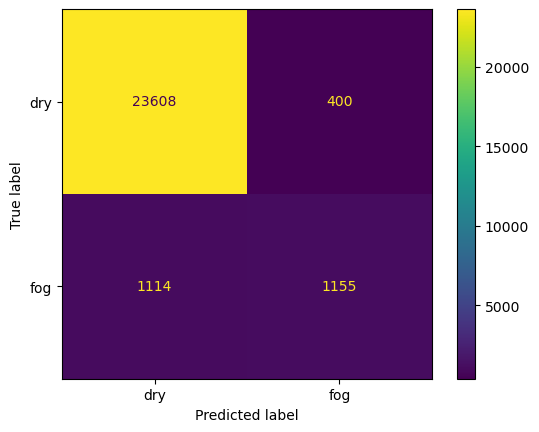

In [ ]:
src_fname = 'sauc-summer-clean-2003-2008.csv'
src_fpath = os.path.join(src_datadir, src_fname)
df = prep_data(src_fpath, var_subset=var_subset)
df = df.loc[~df['condition'].isin(['both', 'rain'])]
X, y = split_pred_target(df)
y = fill_fog_periods(y, fill_period=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.3, stratify=y, shuffle=True)
#X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_train, y_train)
fog_classifier = rf.fit(X_train, y_train)
y_pred = fog_classifier.predict(X_test)

# Get metrics 
metrics = get_metrics(y_test, y_pred)
print(metrics)

# Plot Confusion Matrix 
plot_cm(y_test, y_pred, labels=['dry', 'fog'])

## UPEM 

In [278]:
src_fname = 'upem-summer-clean-2005-2010.csv'
src_fpath = os.path.join(src_datadir, src_fname)

# Run with all variables 
cv_results = cv_wrapper(src_fpath, rf)
mean_score = round(np.average(cv_results), 3)
print("Full Dataset Mean F1 Score:", mean_score)

cv_dict["site"].append('UPEM')
cv_dict["subset"].append(False)
cv_dict["mean_score"].append(mean_score)

# Run with subset
cv_results = cv_wrapper(src_fpath, rf, var_subset)
mean_score = round(np.average(cv_results), 3)
print("Data Subset Mean F1 Score:", mean_score)

cv_dict["site"].append('UPEM')
cv_dict["subset"].append(True)
cv_dict["mean_score"].append(mean_score)

[0.8187826  0.81550797 0.83673595 0.83281491 0.8212572 ]
Full Dataset Mean F1 Score: 0.825
[0.798268   0.78761707 0.80307101 0.8077885  0.79649696]
Data Subset Mean F1 Score: 0.799


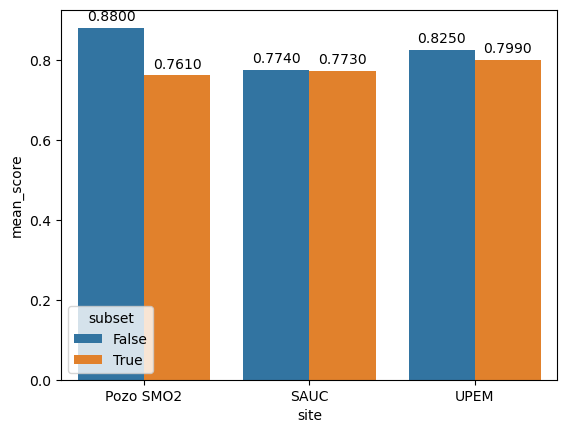

In [ ]:
cv_df = pd.DataFrame(cv_dict)
ax = sns.barplot(data=cv_df,
        x="site",
        y="mean_score",
        hue='subset')
for bars in ax.containers:  # Iterate through each subset (container of bars)
    ax.bar_label(bars, fmt='%.4f', label_type='edge', padding=3)
plt.show()

# Train model on Pozo and apply elsewhere
Determine how well a model trained on Pozo data applies elsewhere.

## Train on Pozo

In [280]:
src_fname = 'sci-pozo-smo2-clean-2021-2023.csv'
src_fpath = os.path.join(src_datadir, src_fname)
train_df = prep_data(src_fpath, var_subset=var_subset)
train_df= train_df.loc[~train_df['condition'].isin(['both', 'rain'])]
X_train, y_train = split_pred_target(train_df)
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_train, y_train)
fog_classifier = rf.fit(X_resampled, y_resampled)

## Apply to SAUC

{'Accuracy': 0.861, 'Balanced Accuracy': np.float64(0.651), 'Recall': 0.651, 'Precision': 0.593, 'F1': 0.61}


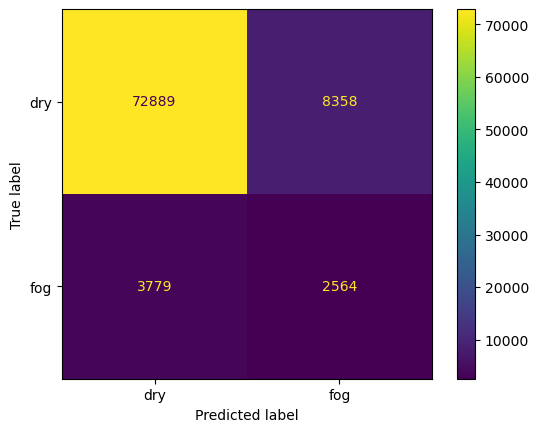

In [ ]:
src_fname = 'sauc-summer-clean-2003-2008.csv'
src_fpath = os.path.join(src_datadir, src_fname)
test_df = prep_data(src_fpath, var_subset=var_subset)
test_df= test_df.loc[~test_df['condition'].isin(['both', 'rain'])]
X_test, y_test = split_pred_target(test_df)
y_pred = fog_classifier.predict(X_test)

# Get metrics 
metrics = get_metrics(y_test, y_pred)
print(metrics)

# Plot Confusion Matrix 
plot_cm(y_test, y_pred, labels=['dry', 'fog'])

## Apply to UPEM

{'Accuracy': 0.876, 'Balanced Accuracy': np.float64(0.743), 'Recall': 0.743, 'Precision': 0.626, 'F1': 0.656}


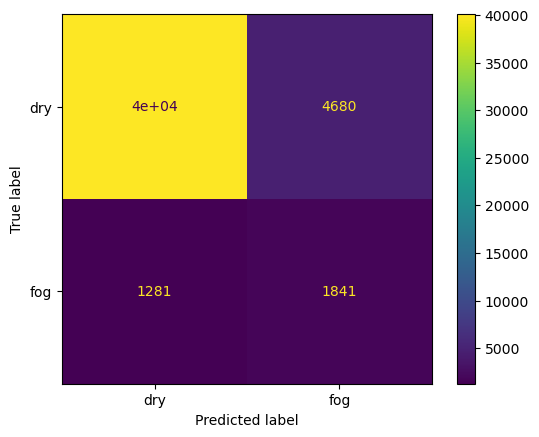

In [282]:
src_fname = 'upem-summer-clean-2005-2010.csv'
src_fpath = os.path.join(src_datadir, src_fname)
test_df = prep_data(src_fpath, var_subset=var_subset)
test_df= test_df.loc[~test_df['condition'].isin(['both', 'rain'])]
X_test, y_test = split_pred_target(test_df)
y_pred = fog_classifier.predict(X_test)

# Get metrics 
metrics = get_metrics(y_test, y_pred)
print(metrics)

# Plot Confusion Matrix 
plot_cm(y_test, y_pred, labels=['dry', 'fog'])

# Train and test on combined dataset

{'Accuracy': 0.806, 'Balanced Accuracy': np.float64(0.707), 'Recall': 0.707, 'Precision': 0.68, 'F1': 0.691}


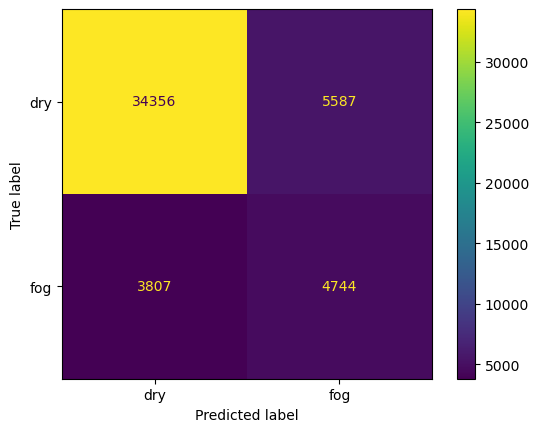

In [ ]:
src_fname = 'sci-sites-joined.csv'
src_fpath = os.path.join(src_datadir, src_fname)
df = prep_data(src_fpath, var_subset=var_subset)
df= df.loc[~df['condition'].isin(['both', 'rain'])]
X, y = split_pred_target(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.3, shuffle=True)
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_train, y_train)
fog_classifier = rf.fit(X_resampled, y_resampled)
y_pred = fog_classifier.predict(X_test)

# Get metrics 
metrics = get_metrics(y_test, y_pred)
print(metrics)

# Plot Confusion Matrix 
plot_cm(y_test, y_pred, labels=['dry', 'fog'])